# Import library

In [138]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error


# Load train, test data

In [139]:
for dirname, _, filenames in os.walk('/home/thien/project/kaggle/house_pricing'):
    for filename in filenames:
        if filename.endswith('.csv'):
            print(os.path.join(dirname, filename))

/home/thien/project/kaggle/house_pricing/submission.csv
/home/thien/project/kaggle/house_pricing/home_data/test.csv
/home/thien/project/kaggle/house_pricing/home_data/train.csv
/home/thien/project/kaggle/house_pricing/home_data/sample_submission.csv


In [140]:
# Read the data
X = pd.read_csv('home_data/train.csv', index_col='Id')
X_test_full = pd.read_csv('home_data/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
print(X.shape)
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
print(X.shape)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

(1460, 80)
(1460, 80)


[0]	validation_0-rmse:71882.27584	validation_1-rmse:76653.03564
[1]	validation_0-rmse:65972.67409	validation_1-rmse:71107.61439
[2]	validation_0-rmse:60646.11290	validation_1-rmse:66572.74621
[3]	validation_0-rmse:55845.48496	validation_1-rmse:63014.67460
[4]	validation_0-rmse:51480.30235	validation_1-rmse:59849.38379
[5]	validation_0-rmse:47510.23817	validation_1-rmse:57002.10316
[6]	validation_0-rmse:43972.64982	validation_1-rmse:53996.03811
[7]	validation_0-rmse:40694.91362	validation_1-rmse:51277.64139
[8]	validation_0-rmse:37728.70384	validation_1-rmse:48669.01129
[9]	validation_0-rmse:35076.48014	validation_1-rmse:47032.97907
[10]	validation_0-rmse:32661.66859	validation_1-rmse:45143.54993
[11]	validation_0-rmse:30465.78804	validation_1-rmse:43856.15619
[12]	validation_0-rmse:28475.26293	validation_1-rmse:42838.57110
[13]	validation_0-rmse:26672.56646	validation_1-rmse:41687.63167
[14]	validation_0-rmse:25026.94651	validation_1-rmse:40929.40765
[15]	validation_0-rmse:23519.46009	

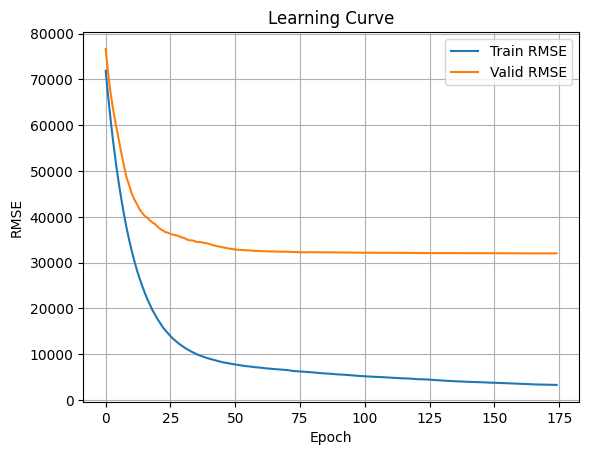

In [141]:
my_model_2 = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping_rounds=10, random_state=0, eval_metric="rmse")

# Fit the model
my_model_2.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_valid, y_valid)],
               verbose=True)

# Get predictions
predictions_2 = my_model_2.predict(X_valid)

rmse = root_mean_squared_error(y_valid, predictions_2)
print("Root Mean Squared Error:", rmse)

evals_result = {}
evals_result = my_model_2.evals_result()
results = evals_result
epochs = len(results["validation_0"]["rmse"])

plt.plot(range(epochs), results["validation_0"]["rmse"], label='Train RMSE')
plt.plot(range(epochs), results["validation_1"]["rmse"], label='Valid RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [142]:
y_pred = my_model_2.predict(X_test)
print(y_pred[:5])
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': y_pred})
output.to_csv('submission.csv', index=False)

[121500.82 153694.78 179444.47 190600.16 192754.36]


# Final model

In [143]:
# # "Cardinality" means the number of unique values in a column
# # Select categorical columns with relatively low cardinality (convenient but arbitrary)
# low_cardinality_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
#                         X[cname].dtype == "object"]

# # Select numeric columns
# numeric_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# # Keep selected columns only
# my_cols = low_cardinality_cols + numeric_cols
# X_train = X[my_cols].copy()
# X_test = X_test_full[my_cols].copy()

# # One-hot encode the data (to shorten the code, we use pandas)
# X_train = pd.get_dummies(X_train)
# X_test = pd.get_dummies(X_test)
# X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [144]:
# my_model_2 = XGBRegressor(n_estimators=50000, learning_rate=0.05, random_state=0, eval_metric="rmse")

# # Fit the model
# my_model_2.fit(X_train, y, verbose=True)

In [145]:
# y_pred = my_model_2.predict(X_test)
# print(y_pred[:5])
# output = pd.DataFrame({'Id': X_test.index, 'SalePrice': y_pred})
# output.to_csv('submission.csv', index=False)